## Transforming data
Polars has very flexible methods for transforming data in a DataFrame, using the `select` and `with_columns` methods.

We previously used `select` to select and reorder columns. We can also use various expressions to modify columns while we're at it. For example, we can take the `-1` placeholder values that indicating missing data and replace them with a missing-data indicator.

First, let's look at the `"response"` and `"RT"` columns again. The first trials are during the study phase, so they are undefined.

In [2]:
import polars as pl
raw = pl.read_csv("exp1.csv")
raw.head()

cycle,trial,phase,type,word1,word2,response,RT,correct,lag,serPos1,serPos2,subj,intactLag,prevResponse,prevRT
i64,i64,str,str,str,str,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64
0,-1,"""study""","""intact""","""formal""","""positive""",-1,-1.0,-1,-1,0,0,101,0,0,0
0,0,"""study""","""intact""","""skin""","""careful""",-1,-1.0,-1,-1,1,1,101,0,0,0
0,1,"""study""","""intact""","""upon""","""miss""",-1,-1.0,-1,-1,2,2,101,0,0,0
0,2,"""study""","""intact""","""single""","""tradition""",-1,-1.0,-1,-1,3,3,101,0,0,0
0,3,"""study""","""intact""","""prove""","""airport""",-1,-1.0,-1,-1,4,4,101,0,0,0


In [3]:
columns = [
    "subj", 
    "cycle", 
    "trial", 
    "phase", 
    "type", 
    "word1", 
    "word2", 
    "response", 
    "RT", 
    "correct", 
    "lag",
]
df = raw.select(columns)
df.head()

subj,cycle,trial,phase,type,word1,word2,response,RT,correct,lag
i64,i64,i64,str,str,str,str,i64,f64,i64,i64
101,0,-1,"""study""","""intact""","""formal""","""positive""",-1,-1.0,-1,-1
101,0,0,"""study""","""intact""","""skin""","""careful""",-1,-1.0,-1,-1
101,0,1,"""study""","""intact""","""upon""","""miss""",-1,-1.0,-1,-1
101,0,2,"""study""","""intact""","""single""","""tradition""",-1,-1.0,-1,-1
101,0,3,"""study""","""intact""","""prove""","""airport""",-1,-1.0,-1,-1


In [4]:
df.select(["response", "RT"]).head()

response,RT
i64,f64
-1,-1.0
-1,-1.0
-1,-1.0
-1,-1.0
-1,-1.0


We can replace the `-1` values with a `null` marker that will indicate that they represent missing data. To change columns, instead of just selecting them, we must use `pl.col` expressions. Here, we'll select the `"response"` and `"RT"` columns and then call the `replace` method to change their values. Setting a value in a column to `None` indicates that the data are missing. This will look like `null` in the DataFrame.

In [5]:
df.select(pl.col("response", "RT").replace(-1, None)).head()

response,RT
i64,f64
null,null
null,null
null,null
null,null
null,null


Setting missing data correctly is important to avoid skewing descriptive statistics. For example, if we want to calculate the mean response time, we don't want a bunch of `-1`s in there.

Instead of using `select`, we can also use `with_columns` if we want to keep the other columns that we aren't specifically defining. Let's also check for `-1` values in the `"correct"` and `"lag"` fields while we're at it.

In [6]:
df_null = df.with_columns(pl.col("response", "RT", "correct", "lag").replace(-1, None))
df_null.head()

subj,cycle,trial,phase,type,word1,word2,response,RT,correct,lag
i64,i64,i64,str,str,str,str,i64,f64,i64,i64
101,0,-1,"""study""","""intact""","""formal""","""positive""",null,null,null,null
101,0,0,"""study""","""intact""","""skin""","""careful""",null,null,null,null
101,0,1,"""study""","""intact""","""upon""","""miss""",null,null,null,null
101,0,2,"""study""","""intact""","""single""","""tradition""",null,null,null,null
101,0,3,"""study""","""intact""","""prove""","""airport""",null,null,null,null


In [7]:
columns = [
    "subj", 
    "cycle", 
    "trial", 
    "phase", 
    "type", 
    "word1", 
    "word2", 
    "response", 
    "RT", 
    "correct", 
    "lag",
]
df = (
    df.select(pl.col(columns))
    .with_columns(
        pl.col("response", "RT", "correct", "lag").replace(-1, None)
    )
)
df.head()

subj,cycle,trial,phase,type,word1,word2,response,RT,correct,lag
i64,i64,i64,str,str,str,str,i64,f64,i64,i64
101,0,-1,"""study""","""intact""","""formal""","""positive""",null,null,null,null
101,0,0,"""study""","""intact""","""skin""","""careful""",null,null,null,null
101,0,1,"""study""","""intact""","""upon""","""miss""",null,null,null,null
101,0,2,"""study""","""intact""","""single""","""tradition""",null,null,null,null
101,0,3,"""study""","""intact""","""prove""","""airport""",null,null,null,null


In [8]:
df_test = (
    df.with_columns(
        pl.col("response", "RT", "correct", "lag").replace(-1, None)
    )
    .filter(pl.col("phase") == "test")
)
df_test.head()

subj,cycle,trial,phase,type,word1,word2,response,RT,correct,lag
i64,i64,i64,str,str,str,str,i64,f64,i64,i64
101,0,-1,"""test""","""rearranged""","""waste""","""degree""",0,2.312,1,2
101,0,0,"""test""","""rearranged""","""needed""","""able""",0,3.542,1,1
101,0,1,"""test""","""rearranged""","""single""","""clean""",0,2.084,1,3
101,0,2,"""test""","""rearranged""","""train""","""useful""",0,1.669,1,2
101,0,3,"""test""","""rearranged""","""knees""","""various""",0,2.326,1,5


In [9]:
# exclude trials where the response was faster than 0.2 s
df_filt = (
    df_test.with_columns(
        pl.when(pl.col("RT") < .2)
        .then(None)
        .otherwise(pl.col("RT"))
        .alias("RT"),
    )
    .with_columns(
        pl.when(pl.col("RT").is_null())
        .then(None)
        .otherwise(pl.col("response"))
        .alias("response")
    )
)
df_filt.describe()

statistic,subj,cycle,trial,phase,type,word1,word2,response,RT,correct,lag
str,f64,f64,f64,str,str,str,str,f64,f64,f64,f64
"""count""",53700.0,53700.0,53700.0,"""53700""","""53700""","""53700""","""53700""",53571.0,53571.0,53700.0,26850.0
"""null_count""",0.0,0.0,0.0,"""0""","""0""","""0""","""0""",129.0,129.0,0.0,26850.0
"""mean""",165.655866,3.496089,28.5,null,null,null,null,0.37384,1.335209,0.656648,3.0
"""std""",99.008229,2.289598,17.318264,null,null,null,null,0.483827,0.756055,0.474832,1.41424
"""min""",101.0,0.0,-1.0,"""test""","""intact""","""ability""","""ability""",0.0,0.212,0.0,1.0
"""25%""",128.0,1.0,14.0,null,null,null,null,0.0,0.883,0.0,2.0
"""50%""",158.0,3.0,29.0,null,null,null,null,0.0,1.126,1.0,3.0
"""75%""",186.0,5.0,43.0,null,null,null,null,1.0,1.527,1.0,4.0
"""max""",1150.0,7.0,58.0,"""test""","""rearranged""","""youth""","""youth""",1.0,7.925,1.0,5.0


In [10]:
(
    df_filt.group_by("subj", "type")
    .agg(pl.col("response").mean())
    .group_by("type")
    .agg(pl.col("response").mean())
)

type,response
str,f64
"""rearranged""",0.216304
"""intact""",0.531784


In [11]:
resp = (
    df_filt.group_by("subj", "type")
    .agg(pl.col("response").mean())
    .sort("subj", "type")
)
tab = (
    resp.pivot("type", index="subj", values="response")
    .select(subj="subj", hr="intact", far="rearranged")
)
tab

subj,hr,far
i64,f64,f64
101,0.76569,0.108333
102,0.2875,0.241667
103,0.866667,0.091667
104,0.508333,0.3875
105,0.575,0.372385
…,…,…
210,0.209205,0.15
211,0.495833,0.179167
212,0.564854,0.52766


<Axes: xlabel='type', ylabel='response'>

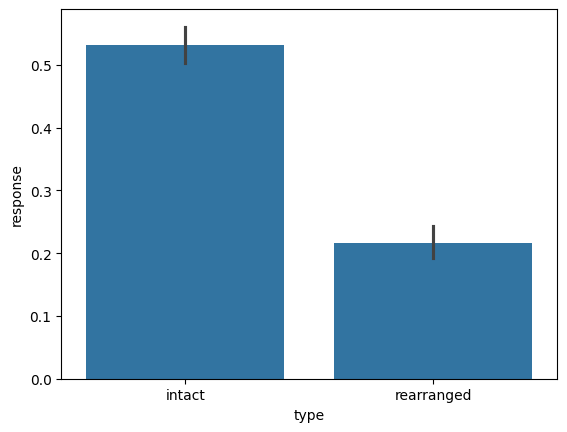

In [12]:
import seaborn as sns
sns.barplot(resp, x="type", y="response")

In [13]:
resp_lag = (
    df_filt.filter(pl.col("type") == "rearranged")
    .group_by("subj", "lag")
    .agg(pl.col("response").mean())
    .sort("subj", "lag")
)
resp_lag

subj,lag,response
i64,i64,f64
101,1,0.0625
101,2,0.1875
101,3,0.0625
101,4,0.125
101,5,0.104167
…,…,…
1150,1,0.270833
1150,2,0.1875
1150,3,0.166667


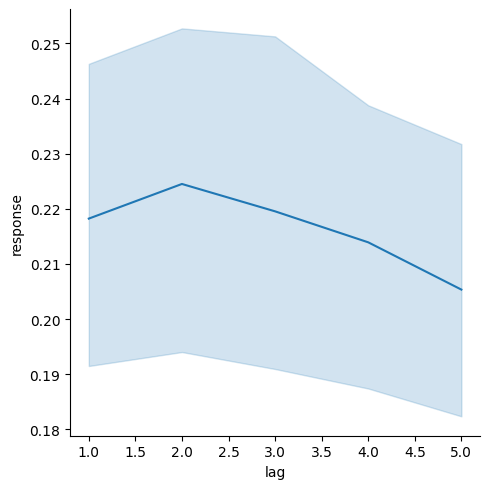

In [14]:
sns.relplot(resp_lag, x="lag", y="response", kind="line")